## Salesforce 1B: Market Mood to Financial Moves
### data preprocessing + feat engineering

This goal of this notebook is to go through data processing steps on the yFinance and Kaggle Financial News Headlines data.

## Yfinance Data

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
df = yf.download("SPY", start="2017-12-30", end="2020-07-19")
df.head()
original = df.copy()

/tmp/ipython-input-597691841.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("SPY", start="2017-12-30", end="2020-07-19")
[*********************100%***********************]  1 of 1 completed


In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
start_date = df.index.min()
end_date = df.index.max()

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
num_business_days = len(pd.date_range(start=start_date, end=end_date, freq=us_bd))

print(f"Number of rows in the data: {df.shape[0]}")
print(f"Number of business days between {start_date.date()} and {end_date.date()}: {num_business_days}")
print("\nDate range in the data:")
print(f"Start date: {start_date.date()}")
print(f"End date: {end_date.date()}")

Number of rows in the data: 640
Number of business days between 2018-01-02 and 2020-07-17: 640

Date range in the data:
Start date: 2018-01-02
End date: 2020-07-17


In [ ]:
df.isnull().sum()

,,0
Price,Ticker,
Close,SPY,0
High,SPY,0
Low,SPY,0
Open,SPY,0
Volume,SPY,0


## EDA on data

first we want to inspect the patterns of the opening prices over time for the SPY stock

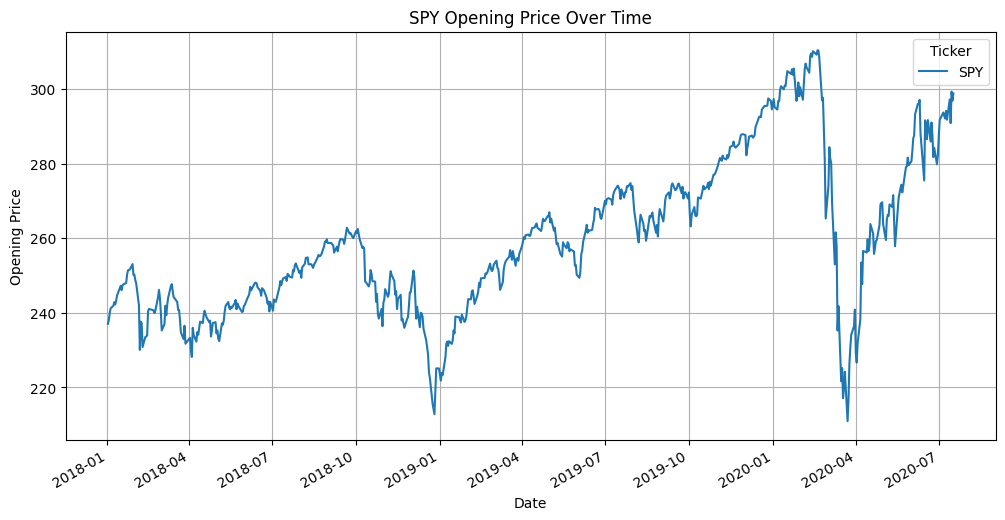

In [ ]:
df['Open'].plot(figsize=(12, 6), title='SPY Opening Price Over Time')
plt.xlabel('Date')
plt.ylabel('Opening Price')
plt.grid(True)
plt.show()

The SPY opening price from 2018-2020 exhibits a general upward trend with a steady increase from ~240 to ~300. There is a however, a sharp drop during early 2020 which is likely reflective of the COVID market crash at the time. This is followed by a strong rebound.

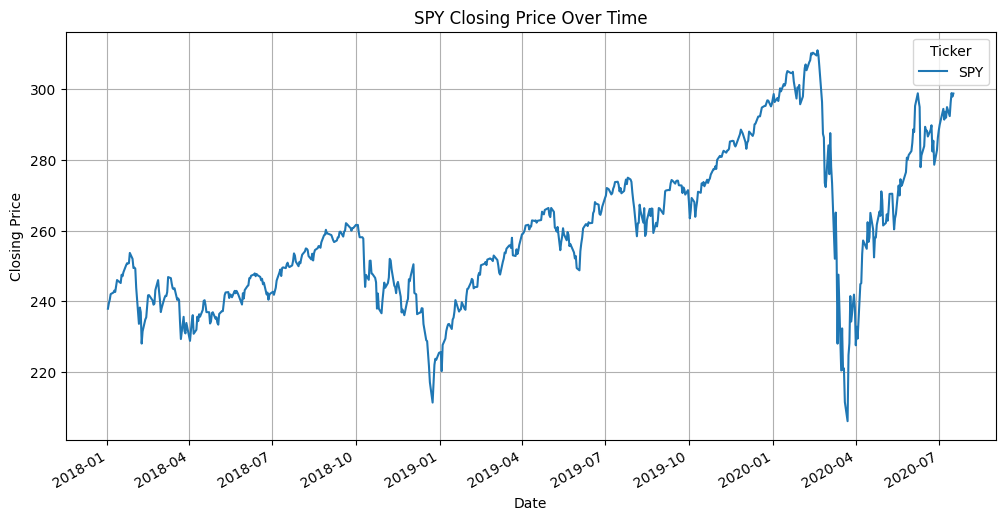

In [ ]:
df['Close'].plot(figsize=(12, 6), title='SPY Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

We observe the same trends in closing price which makes sense.

We'll proceed with using the closing price as that would be the easiest to use to predict the next day's opening price.

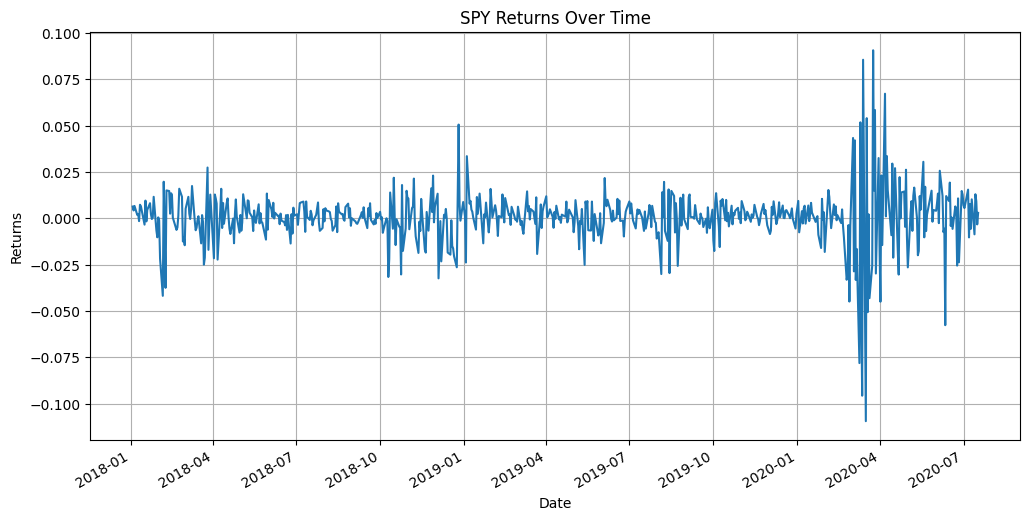

In [ ]:
df['Return'] = df['Close'].pct_change()
df['Return'].plot(figsize=(12, 6), title='SPY Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)
plt.show()

daily returns observations:
- most daily returns are very small, typically within the -1% to +1% range
- occasional large spikes during major market events (COVID)
- voltality is not constant
- small movements in market might be difficult to predict using new headlines..
  - threshold-based labeling?

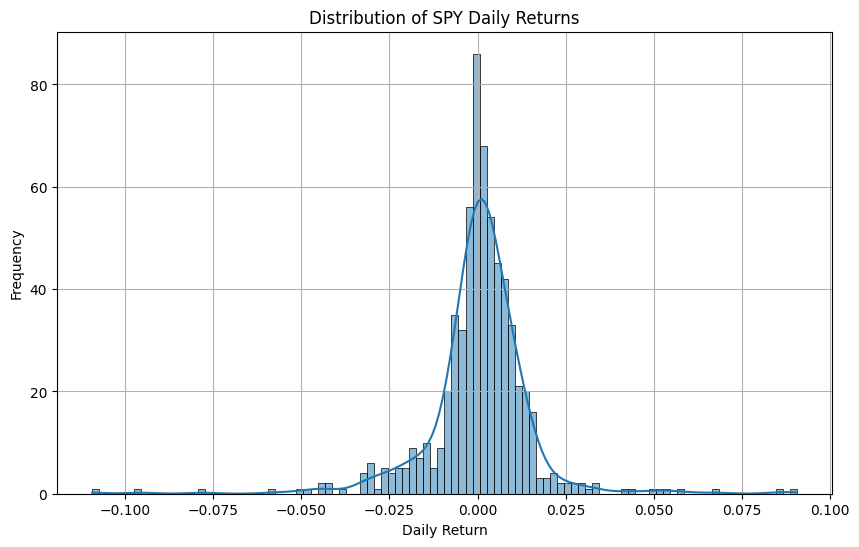

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Return'].dropna(), bins=100, kde=True)
plt.title("Distribution of SPY Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

the distribution of returns tells us that small movements are VERY common.

In [ ]:
df['Volatility_20'] = df['Return'].rolling(20).std()

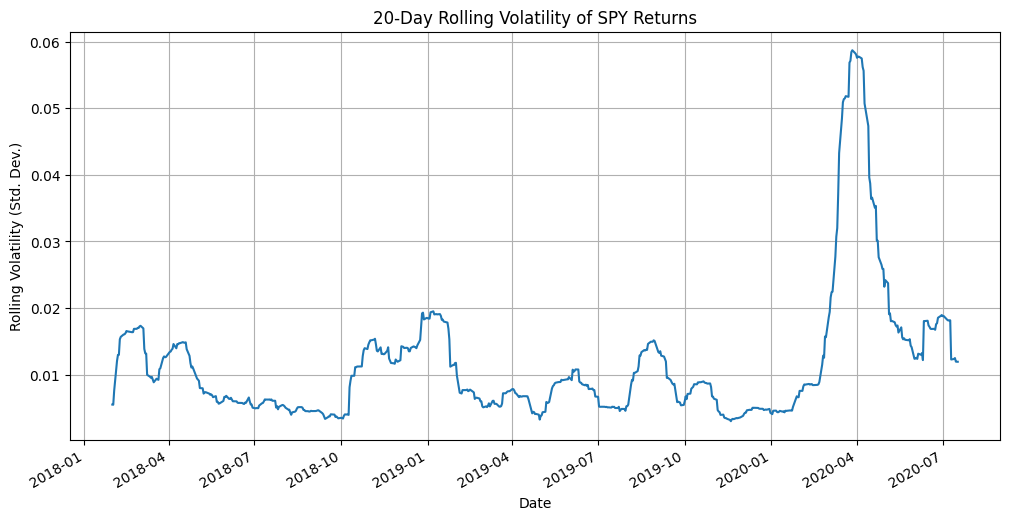

In [ ]:
plt.figure(figsize=(12, 6))
df['Volatility_20'].plot()
plt.title('20-Day Rolling Volatility of SPY Returns')
plt.xlabel('Date')
plt.ylabel('Rolling Volatility (Std. Dev.)')
plt.grid(True)
plt.show()

voltality is generally low, other than during the covid spike.

In [ ]:
df['Next_Open_SPY'] = df['Open'].shift(-1)

Now we'll inspect the data to find days where there may have been extreme spikes in returns/ losses.

In [ ]:
worst = df.nsmallest(10, 'Return')[['Return']]
worst

Price,Return
Ticker,
Date,
2020-03-16,-0.109424
2020-03-12,-0.095677
2020-03-09,-0.078095
2020-06-11,-0.057649
2020-03-18,-0.050633
2020-03-11,-0.048749
2020-04-01,-0.045005
2020-02-27,-0.044912


In [ ]:
best = df.nlargest(10, 'Return')[['Return']]
best

Price,Return
Ticker,
Date,
2020-03-24,0.090604
2020-03-13,0.085486
2020-04-06,0.067166
2020-03-26,0.058390
2020-03-17,0.053992
2020-03-10,0.051745
2018-12-26,0.050525
2020-03-02,0.043306


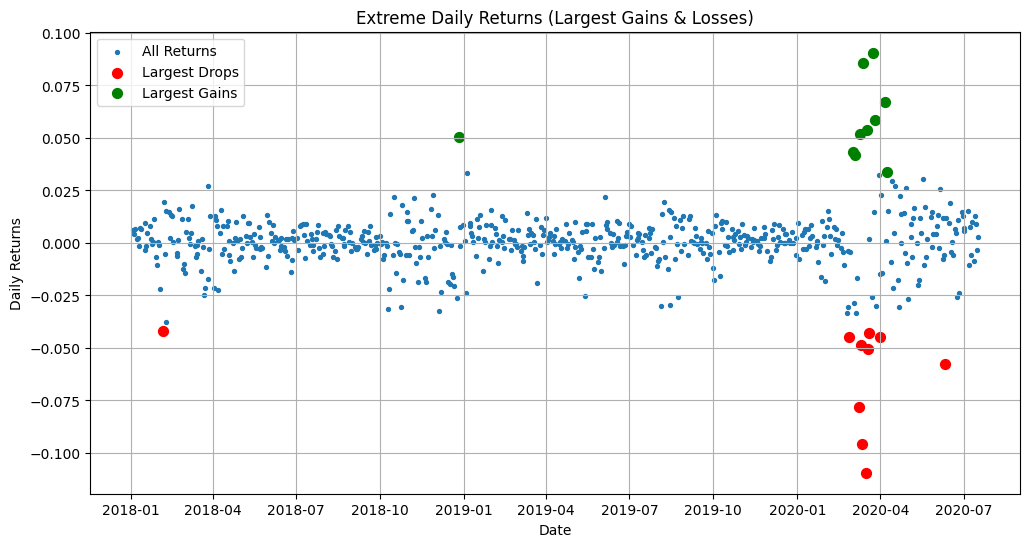

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Return'], s=8, label='All Returns')
plt.scatter(worst.index, worst['Return'], color='red', s=50, label='Largest Drops')
plt.scatter(best.index, best['Return'], color='green', s=50, label='Largest Gains')
plt.title("Extreme Daily Returns (Largest Gains & Losses)")
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.grid(True)
plt.legend()
plt.show()

- largest negative returns mostly occur in marc/april 2020, during the COVID market crash, with drops between -5% and -11%.

- largest positive returns also appear in early 2020 with rebound days with gains of +5% to +9%.

- one notable outlier before 2020 (~ -4.5% in early 2018)

- outside of crisis periods, extreme moves are much smaller

- fat-tailed nature of data of returns show that major news events drive the biggest market movements

now that we've done intial EDA on the yfinance set, we will begin feature engineering for specific variables in this dataset

## feature engineering for predicting opening price

In [ ]:
# removing the multiindex
base_cols = [c for c in ["Close", "High", "Low", "Open", "Volume"] if c in df.columns]
price_df = original[base_cols].copy()

In [ ]:
if isinstance(price_df.columns, pd.MultiIndex):
    price_df.columns = [
        "_".join([str(c) for c in col if c])
        for col in price_df.columns.to_flat_index()
    ]
price_df = price_df.loc[:, ~price_df.columns.duplicated()]

In [ ]:
# Rename for SPY
price_df = price_df.rename(columns={
    "Close":  "Close_SPY",
    "High":   "High_SPY",
    "Low":    "Low_SPY",
    "Open":   "Open_SPY",
    "Volume": "Volume_SPY",
})

# Base daily return
if "Return" not in price_df.columns:
    price_df["Return"] = price_df["Close_SPY"].pct_change()

# Intraday Price Structure
price_df["High_Low_Spread"]   = price_df["High_SPY"] - price_df["Low_SPY"]
price_df["Close_Open_Change"] = price_df["Close_SPY"] - price_df["Open_SPY"]
price_df["Close_to_High"]     = price_df["High_SPY"] - price_df["Close_SPY"]
price_df["Close_to_Low"]      = price_df["Close_SPY"] - price_df["Low_SPY"]

# Returns, Lags & Momentum
price_df["Return_1"] = price_df["Return"].shift(1)
price_df["Return_2"] = price_df["Return"].shift(2)
price_df["Return_3"] = price_df["Return"].shift(3)

price_df["Return_5"]  = price_df["Close_SPY"].pct_change(5)
price_df["Return_10"] = price_df["Close_SPY"].pct_change(10)

price_df["Momentum_3"] = price_df["Close_SPY"] / price_df["Close_SPY"].shift(3) - 1
price_df["Momentum_7"] = price_df["Close_SPY"] / price_df["Close_SPY"].shift(7) - 1

price_df["Close_lag1"] = price_df["Close_SPY"].shift(1)
price_df["Close_lag2"] = price_df["Close_SPY"].shift(2)
price_df["Close_lag3"] = price_df["Close_SPY"].shift(3)

# Moving Averages
price_df["MA_5"]  = price_df["Close_SPY"].rolling(5).mean()
price_df["MA_20"] = price_df["Close_SPY"].rolling(20).mean()

price_df["Close_minus_MA_5"]  = price_df["Close_SPY"] - price_df["MA_5"]
price_df["Close_minus_MA_20"] = price_df["Close_SPY"] - price_df["MA_20"]

# Volatility
price_df["Volatility_5"]  = price_df["Return"].rolling(5).std()
price_df["Volatility_10"] = price_df["Return"].rolling(10).std()
if "Volatility_20" not in price_df.columns:
    price_df["Volatility_20"] = price_df["Return"].rolling(20).std()

# ATR
price_df["TR"] = price_df.apply(
    lambda row: max(
        row["High_SPY"] - row["Low_SPY"],
        abs(row["High_SPY"] - row["Close_SPY"]),
        abs(row["Low_SPY"] - row["Close_SPY"])
    ),
    axis=1
)
price_df["ATR_14"] = price_df["TR"].rolling(14).mean()

# Overnight / Gap
price_df["Prev_Day_Overnight_Return"] = (
    price_df["Open_SPY"] / price_df["Close_SPY"].shift(1) - 1
)

# Calendar
price_df["day_of_week"]    = price_df.index.dayofweek
price_df["month"]          = price_df.index.month
price_df["day_of_month"]   = price_df.index.day
price_df["week_of_month"]  = (price_df.index.day - 1) // 7
price_df["is_month_end"]   = price_df.index.is_month_end.astype(int)
price_df["is_quarter_end"] = price_df.index.is_quarter_end.astype(int)

# Target
price_df["Next_Open_SPY"] = price_df["Open_SPY"].shift(-1)


In [ ]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 640 entries, 2018-01-02 to 2020-07-17
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Close_SPY                  640 non-null    float64
 1   High_SPY                   640 non-null    float64
 2   Low_SPY                    640 non-null    float64
 3   Open_SPY                   640 non-null    float64
 4   Volume_SPY                 640 non-null    int64  
 5   Return                     639 non-null    float64
 6   High_Low_Spread            640 non-null    float64
 7   Close_Open_Change          640 non-null    float64
 8   Close_to_High              640 non-null    float64
 9   Close_to_Low               640 non-null    float64
 10  Return_1                   638 non-null    float64
 11  Return_2                   637 non-null    float64
 12  Return_3                   636 non-null    float64
 13  Return_5                   635 

In [ ]:
price_df.isna().sum()

,0
Close_SPY,0
High_SPY,0
Low_SPY,0
Open_SPY,0
Volume_SPY,0
Return,1
High_Low_Spread,0
Close_Open_Change,0
Close_to_High,0
Close_to_Low,0


## Financial News Headlines Dataset

In [ ]:
import kagglehub
path = kagglehub.dataset_download("notlucasp/financial-news-headlines")

Using Colab cache for faster access to the 'financial-news-headlines' dataset.


In [ ]:
cnbc = pd.read_csv(path + "/cnbc_headlines.csv")
guardian = pd.read_csv(path + "/guardian_headlines.csv")
reuters = pd.read_csv(path + "/reuters_headlines.csv")

# convert to dataframes
cnbc_df = pd.DataFrame(cnbc)
guardian_df = pd.DataFrame(guardian)
reuters_df = pd.DataFrame(reuters)

In [ ]:
cnbc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    2800 non-null   object
 1   Time         2800 non-null   object
 2   Description  2800 non-null   object
dtypes: object(3)
memory usage: 72.3+ KB


In [ ]:
cnbc_df["Description"][0]

'"Mad Money" host Jim Cramer recommended buying four companies that are supporting vaccine developers.'

In [ ]:
guardian_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17800 entries, 0 to 17799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       17800 non-null  object
 1   Headlines  17800 non-null  object
dtypes: object(2)
memory usage: 278.3+ KB


In [ ]:
reuters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32770 entries, 0 to 32769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    32770 non-null  object
 1   Time         32770 non-null  object
 2   Description  32770 non-null  object
dtypes: object(3)
memory usage: 768.2+ KB


In [ ]:
reuters_df["Description"][0]

'TikTok has been in discussions with the UK government over the past few months to locate its headquarters in London, a source familiar with the matter said, as part of a strategy to distance itself from its Chinese ownership.'

Of the three new sources, it looks like guardian is the only one without a description. for sake of maintaining consistency across sources and avoiding introducing variable-length text bias, we will keep only the headline field for all datasets. Headlines itself already provides concise, high-signal information.

In [ ]:
cnbc_df = cnbc_df.rename(columns={'Headlines': 'headline'})
guardian_df = guardian_df.rename(columns={'Headlines': 'headline'})
reuters_df = reuters_df.rename(columns={'Headlines': 'headline'})
# source
cnbc_df['source'] = 'cnbc'
guardian_df['source'] = 'guardian'
reuters_df['source'] = 'reuters'

converting the dates across all 3 sources to be the same format.

In [ ]:
# parsing for guardian and reuters
guardian_df['date'] = pd.to_datetime(guardian_df['Time'], format="%d-%b-%y", errors='coerce')
reuters_df['date'] = pd.to_datetime(reuters_df['Time'], format="%b %d %Y", errors='coerce')

In [ ]:
import re
from dateutil import parser

def parse_cnbc_time(time_str):
    if pd.isna(time_str):
        return None
    match = re.search(r",\s*(.*)", time_str)
    if match:
        date_str = match.group(1)
        try:
            return parser.parse(date_str)
        except:
            return None
    return None

cnbc_df['date'] = cnbc_df['Time'].apply(parse_cnbc_time)

handling missing dates

In [ ]:
cnbc_df['date'].isna().sum()

np.int64(280)

In [ ]:
cnbc_df = cnbc_df.dropna(subset=['headline', 'date'])
guardian_df = guardian_df.dropna(subset=['headline', 'date'])
reuters_df = reuters_df.dropna(subset=['headline', 'date'])

combining the 3 sources

In [ ]:
news_all = pd.concat([cnbc_df[['headline', 'date', 'source']],
                      guardian_df[['headline', 'date', 'source']],
                      reuters_df[['headline', 'date', 'source']]],
                     ignore_index=True)

In [ ]:
news_all.isna().sum()

,0
headline,0
date,0
source,0


now that we have the 3 new sources data merged, we'll proceed with normalizing/cleaning the data.


we'll start with doing the following for each headline:
- lowercase
- remove urls
- remove line breaks/tabs
- remove special chars
- collapse multiple spaces

In [ ]:
!pip install contractions --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00


In [ ]:
import re
import contractions
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def clean_headline(text):
    if pd.isna(text):
        return ""

    text = contractions.fix(text)
    text = text.lower()

    # remove URLs
    text = re.sub(r"http\S+|www\.\S+", " ", text)

    # remove line breaks
    text = text.replace("\n", " ").replace("\r", " ")

    # remove weird symbols
    text = re.sub(r"[^a-z0-9.,%$?!\- ]", " ", text)

    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
news_all['headline_clean'] = news_all['headline'].astype(str).apply(clean_headline)
# drop rows that became empty after cleaning
news_all = news_all[news_all['headline_clean'].str.len() > 0].copy()
news_all.head()

,headline,date,source,headline_clean
0,Jim Cramer: A better way to invest in the Covi...,2020-07-17,cnbc,jim cramer a better way to invest in the covid...
1,Cramer's lightning round: I would own Teradyne,2020-07-17,cnbc,cramer s lightning round i would own teradyne
2,"Cramer's week ahead: Big week for earnings, ev...",2020-07-17,cnbc,"cramer s week ahead big week for earnings, eve..."
3,IQ Capital CEO Keith Bliss says tech and healt...,2020-07-17,cnbc,iq capital ceo keith bliss says tech and healt...
4,Wall Street delivered the 'kind of pullback I'...,2020-07-16,cnbc,wall street delivered the kind of pullback i h...


inspecting the results

In [ ]:
news_all["headline_clean"][50]

'barstool s dave portnoy says he will focus on sports betting when sports return'

In [ ]:
news_all["headline"][50]

"Barstool's Dave Portnoy says he'll focus on sports betting when sports return"

now that we've normalized the format of the headlines we'll work on normalizing the dates and then merging.

In [ ]:
price_df.columns

Index(['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'Return',
       'High_Low_Spread', 'Close_Open_Change', 'Close_to_High', 'Close_to_Low',
       'Return_1', 'Return_2', 'Return_3', 'Return_5', 'Return_10',
       'Momentum_3', 'Momentum_7', 'Close_lag1', 'Close_lag2', 'Close_lag3',
       'MA_5', 'MA_20', 'Close_minus_MA_5', 'Close_minus_MA_20',
       'Volatility_5', 'Volatility_10', 'Volatility_20', 'TR', 'ATR_14',
       'Prev_Day_Overnight_Return', 'day_of_week', 'month', 'day_of_month',
       'week_of_month', 'is_month_end', 'is_quarter_end', 'Next_Open_SPY'],
      dtype='object')

In [ ]:
if not isinstance(price_df.index, pd.DatetimeIndex):
    price_df['Date'] = pd.to_datetime(price_df['Date'])
    price_df = price_df.set_index('Date')
if isinstance(price_df.columns, pd.MultiIndex):
    price_df.columns = ['_'.join(col).strip() for col in price_df.columns.values]
price_df = price_df.sort_index()
trading_days = price_df.index.normalize().unique().sort_values()

In [ ]:
# parsing out just the date
news_all['date'] = pd.to_datetime(news_all['date'], errors='coerce')
news_all['date_only'] = news_all['date'].dt.normalize()
# drop rows where we couldn't parse a date
news_all = news_all.dropna(subset=['date_only'])
trade_df = pd.DataFrame({'trade_date': trading_days}).sort_values('trade_date')
news_all = news_all.sort_values('date_only')

# map each news date to the SAME or NEXT trading day
news_all = pd.merge_asof(
    news_all,
    trade_df,
    left_on='date_only',
    right_on='trade_date',
    direction='forward'   # next trading day
)

# drop anything that mapped past the last trading day
news_all = news_all.dropna(subset=['trade_date'])

If news happens on:
- Weekday/non-holiday: mapped to weekday
- Saturday: mapped to Monday
- Sunday: mapped to Monday

Next we'll aggregate all news headlines; concatenating all headlines from a certain trading day into a single string.

In [ ]:
daily_news = (
    news_all
    .groupby('trade_date')['headline_clean']
    .apply(lambda x: " ".join(x))
    .to_frame(name='headline_concat')
)

In [ ]:
price_df.index = price_df.index.normalize()
merged = price_df.join(daily_news, how='left')
merged.head()

,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Return,High_Low_Spread,Close_Open_Change,Close_to_High,Close_to_Low,...,ATR_14,Prev_Day_Overnight_Return,day_of_week,month,day_of_month,week_of_month,is_month_end,is_quarter_end,Next_Open_SPY,headline_concat
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,237.909088,237.944503,236.696400,237.085880,86655700,NaN,1.248103,0.823208,0.035415,1.212689,...,NaN,NaN,1,1,2,0,0,0,238.077329,the guardian view on ryanair s model a union-f...
2018-01-03,239.413956,239.564448,238.077329,238.077329,90070400,0.006325,1.487119,1.336627,0.150492,1.336627,...,NaN,0.000707,2,1,3,0,0,0,240.060166,business live uk construction growth disappoin...
2018-01-04,240.423065,240.909929,239.475946,240.060166,80636400,0.004215,1.433983,0.362899,0.486864,0.947119,...,NaN,0.002699,3,1,4,0,0,0,241.219784,uk leaving single market for tpp could hit wor...
2018-01-05,242.025299,242.149210,240.724087,241.219784,83524000,0.006664,1.425123,0.805515,0.123911,1.301212,...,NaN,0.003314,4,1,5,0,0,0,241.927847,the guardian s audio long reads manchester cit...
2018-01-08,242.467819,242.627145,241.635750,241.927847,57319200,0.001828,0.991394,0.539972,0.159325,0.832069,...,NaN,-0.000403,0,1,8,1,0,0,242.892694,business live wall street and ftse 100 hit new...


In [ ]:
check_date = "2020-04-09"

merged.loc[check_date][[
    "headline_concat",
    "Next_Open_SPY",
    "Open_SPY"
]]

,2020-04-09
headline_concat,"investors caution cement, steel firms on eu cl..."
Next_Open_SPY,256.209192
Open_SPY,256.615888


In [ ]:
check_date = "2020-04-08"

merged.loc[check_date][[
    "headline_concat",
    "Next_Open_SPY",
    "Open_SPY"
]]

,2020-04-08
headline_concat,nils pratley on finance rolls-royce s self-rel...
Next_Open_SPY,256.615888
Open_SPY,247.722487


In [ ]:
news_all[
    (news_all['trade_date'] == pd.to_datetime(check_date))
][['date', 'date_only', 'headline_clean']].head(20)

,date,date_only,headline_clean
46308,2020-04-08,2020-04-08,nils pratley on finance rolls-royce s self-rel...
46309,2020-04-08,2020-04-08,global leaders urge g20 to tackle twin health ...
46310,2020-04-08,2020-04-08,how false claims about 5g health risks spread ...
46311,2020-04-08,2020-04-08,"jim cramer predicts you shape recovery, says e..."
46312,2020-04-08,2020-04-08,jim cramer spots 8 instant winners after china...
46313,2020-04-08,2020-04-08,cramer s lightning round i like uber more than...
46314,2020-04-08,2020-04-08,this new normal matters for your life and your...
46315,2020-04-08,2020-04-08,salesforce is working to bring another load of...
46316,2020-04-08,2020-04-08,australia s parliament set to pass huge stimul...
46317,2020-04-08,2020-04-08,project syndicate economists world must combat...


In [ ]:
df.shape

(640, 8)

## inspecting merged dataset

In [ ]:
merged.describe()

,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Return,High_Low_Spread,Close_Open_Change,Close_to_High,Close_to_Low,...,TR,ATR_14,Prev_Day_Overnight_Return,day_of_week,month,day_of_month,week_of_month,is_month_end,is_quarter_end,Next_Open_SPY
count,640.000000,640.000000,640.000000,640.000000,6.400000e+02,639.000000,640.000000,640.000000,640.000000,640.000000,...,640.000000,627.000000,639.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,639.000000
mean,259.407779,261.000215,257.653650,259.407356,9.287317e+07,0.000469,3.346565,0.000423,1.592436,1.754129,...,3.346565,3.356248,0.000416,2.023438,5.946875,15.634375,1.685938,0.032813,0.007812,259.442288
std,20.407811,20.100841,20.696187,20.406703,5.588194e+07,0.014991,2.910235,2.462099,2.196584,2.088635,...,2.910235,2.383549,0.010327,1.404580,3.348368,8.732724,1.264585,0.178285,0.088111,20.403531
min,206.111832,212.333548,201.776039,210.956089,2.027000e+07,-0.109424,0.542249,-12.693048,0.000000,0.000000,...,0.542249,1.337797,-0.104485,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,210.956089
25%,243.681824,244.999109,242.047898,243.663882,5.753465e+07,-0.003757,1.539724,-0.831011,0.361480,0.598062,...,1.539724,1.755131,-0.002434,1.000000,3.000000,8.000000,1.000000,0.000000,0.000000,243.700909
50%,257.246414,258.631766,255.201529,257.137257,7.675915e+07,0.000862,2.375747,0.124452,0.822603,1.173611,...,2.375747,2.572856,0.000818,2.000000,6.000000,15.000000,2.000000,0.000000,0.000000,257.216166
75%,272.217773,273.429944,270.671364,272.309796,1.051505e+08,0.006682,3.977625,1.099259,1.841076,2.091347,...,3.977625,4.166474,0.004084,3.000000,9.000000,23.000000,3.000000,0.000000,0.000000,272.314126
max,310.958618,311.638722,310.168230,310.453140,3.922207e+08,0.090604,21.101880,10.797882,17.048773,19.116683,...,21.101880,14.531177,0.060376,4.000000,12.000000,31.000000,4.000000,1.000000,1.000000,310.453140


In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 640 entries, 2018-01-02 to 2020-07-17
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Close_SPY                  640 non-null    float64
 1   High_SPY                   640 non-null    float64
 2   Low_SPY                    640 non-null    float64
 3   Open_SPY                   640 non-null    float64
 4   Volume_SPY                 640 non-null    int64  
 5   Return                     639 non-null    float64
 6   High_Low_Spread            640 non-null    float64
 7   Close_Open_Change          640 non-null    float64
 8   Close_to_High              640 non-null    float64
 9   Close_to_Low               640 non-null    float64
 10  Return_1                   638 non-null    float64
 11  Return_2                   637 non-null    float64
 12  Return_3                   636 non-null    float64
 13  Return_5                   635 

In [ ]:
pd.reset_option('display.max_colwidth')
merged.head()

,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Return,High_Low_Spread,Close_Open_Change,Close_to_High,Close_to_Low,...,ATR_14,Prev_Day_Overnight_Return,day_of_week,month,day_of_month,week_of_month,is_month_end,is_quarter_end,Next_Open_SPY,headline_concat
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,237.909088,237.944503,236.696400,237.085880,86655700,NaN,1.248103,0.823208,0.035415,1.212689,...,NaN,NaN,1,1,2,0,0,0,238.077329,the guardian view on ryanair s model a union-f...
2018-01-03,239.413956,239.564448,238.077329,238.077329,90070400,0.006325,1.487119,1.336627,0.150492,1.336627,...,NaN,0.000707,2,1,3,0,0,0,240.060166,business live uk construction growth disappoin...
2018-01-04,240.423065,240.909929,239.475946,240.060166,80636400,0.004215,1.433983,0.362899,0.486864,0.947119,...,NaN,0.002699,3,1,4,0,0,0,241.219784,uk leaving single market for tpp could hit wor...
2018-01-05,242.025299,242.149210,240.724087,241.219784,83524000,0.006664,1.425123,0.805515,0.123911,1.301212,...,NaN,0.003314,4,1,5,0,0,0,241.927847,the guardian s audio long reads manchester cit...
2018-01-08,242.467819,242.627145,241.635750,241.927847,57319200,0.001828,0.991394,0.539972,0.159325,0.832069,...,NaN,-0.000403,0,1,8,1,0,0,242.892694,business live wall street and ftse 100 hit new...


checking missing values

In [ ]:
merged.isna().sum()

,0
Close_SPY,0
High_SPY,0
Low_SPY,0
Open_SPY,0
Volume_SPY,0
Return,1
High_Low_Spread,0
Close_Open_Change,0
Close_to_High,0
Close_to_Low,0


In [ ]:
merged['headline_concat'] = merged['headline_concat'].fillna("")

In [ ]:
merged.isna().sum()

,0
Close_SPY,0
High_SPY,0
Low_SPY,0
Open_SPY,0
Volume_SPY,0
Return,1
High_Low_Spread,0
Close_Open_Change,0
Close_to_High,0
Close_to_Low,0


Now that we've finished numerical feature engineering, we'll calculate some sentiment scores for additional features

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.0 MB/s eta 0:00:00


**Applying VADER** (a rule-based sentiment analyzer) to each day's combined headlines.

For every headline bundle, VADER outputs four scores:

- neg: proportion of negative emotion

- neu: proportion of neutral content

- pos: proportion of positive emotion

- compound: a single overall sentiment score in [-1, +1]

In [ ]:
features_df = merged.copy()

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
def get_vader_scores(text):
    return analyzer.polarity_scores(text)
vader_dicts = features_df['headline_concat'].apply(get_vader_scores)

In [ ]:
features_df['vader_neg'] = vader_dicts.apply(lambda d: d['neg'])
features_df['vader_neu'] = vader_dicts.apply(lambda d: d['neu'])
features_df['vader_pos'] = vader_dicts.apply(lambda d: d['pos'])
features_df['vader_compound'] = vader_dicts.apply(lambda d: d['compound'])


The compound score is essentially a weighted combination of neg/neu/pos and represents the overall tone:

- close to +1 = very positive

- close to -1 = very negative

These scores were added back to the dataset as numeric features for modeling:

- vader_neg, vader_neu, vader_pos, vader_compound

In [ ]:
features_df[['headline_concat', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']].head()

,headline_concat,vader_neg,vader_neu,vader_pos,vader_compound
Date,,,,,
2018-01-02,the guardian view on ryanair s model a union-f...,0.119,0.769,0.112,-0.9879
2018-01-03,business live uk construction growth disappoin...,0.108,0.747,0.146,0.9413
2018-01-04,uk leaving single market for tpp could hit wor...,0.099,0.779,0.122,0.8974
2018-01-05,the guardian s audio long reads manchester cit...,0.081,0.850,0.069,-0.7039
2018-01-08,business live wall street and ftse 100 hit new...,0.089,0.819,0.092,0.5318


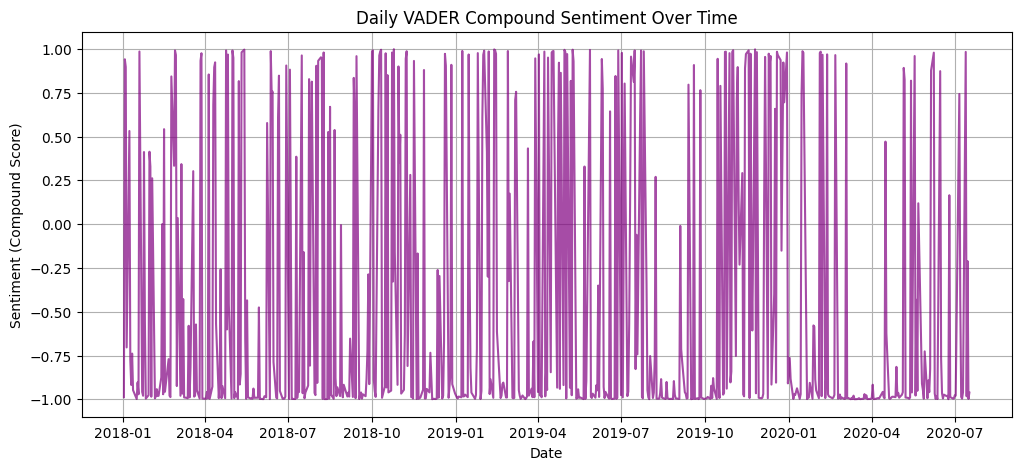

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(features_df.index, features_df['vader_compound'], color='purple', alpha=0.7)
plt.title("Daily VADER Compound Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment (Compound Score)")
plt.grid(True)
plt.show()

very noisy...

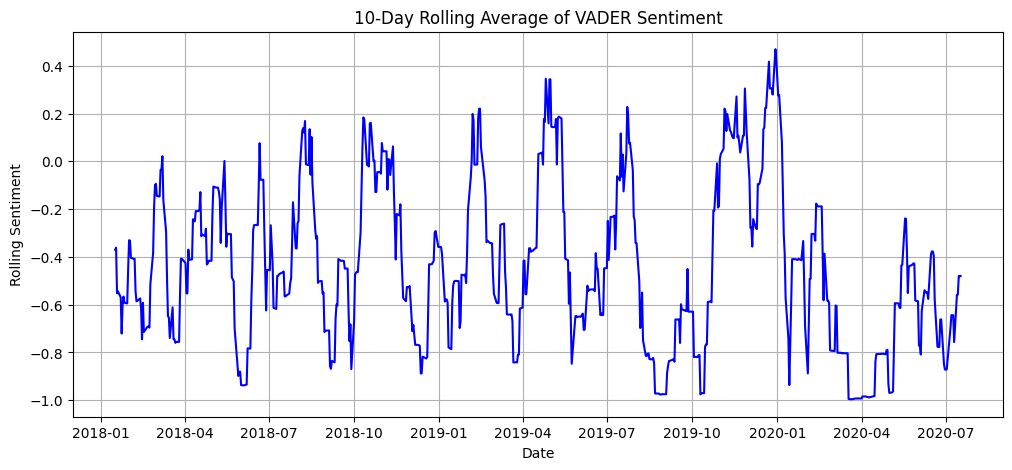

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(features_df['vader_compound'].rolling(10).mean(), color='blue')
plt.title("10-Day Rolling Average of VADER Sentiment")
plt.xlabel("Date")
plt.ylabel("Rolling Sentiment")
plt.grid(True)
plt.show()


meaningful news cycle- periods of positive / negative new waves can be seen

###FINBERT

In [ ]:
!pip install transformers --quiet

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

finbert_model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert"
)
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_pipeline = pipeline(
    "sentiment-analysis",
    model=finbert_model,
    tokenizer=finbert_tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


FinBERT is a finance-specific sentiment model trained on earnings calls, analyst reports, and financial news.

It assigns three probabilities:

- positive

- negative

- neutral

In [ ]:
def finbert_scores(text):
    try:
        scores = finbert_pipeline(text[:512])[0]  # truncate to avoid long input
        out = {d['label'].lower(): d['score'] for d in scores}
        return out
    except:
        return {"positive": 0, "negative": 0, "neutral": 1}

In [ ]:
finbert_dicts = features_df['headline_concat'].apply(finbert_scores)

note: takes about 5mins to execute this

In [ ]:
features_df['finbert_positive'] = finbert_dicts.apply(lambda d: d['positive'])
features_df['finbert_negative'] = finbert_dicts.apply(lambda d: d['negative'])
features_df['finbert_neutral']  = finbert_dicts.apply(lambda d: d['neutral'])

In [ ]:
features_df[['headline_concat','finbert_positive','finbert_negative','finbert_neutral']].head()

,headline_concat,finbert_positive,finbert_negative,finbert_neutral
Date,,,,
2018-01-02,the guardian view on ryanair s model a union-f...,0.060696,0.037543,0.901761
2018-01-03,business live uk construction growth disappoin...,0.871260,0.043647,0.085093
2018-01-04,uk leaving single market for tpp could hit wor...,0.024769,0.917584,0.057646
2018-01-05,the guardian s audio long reads manchester cit...,0.667475,0.048278,0.284247
2018-01-08,business live wall street and ftse 100 hit new...,0.377619,0.535373,0.087008


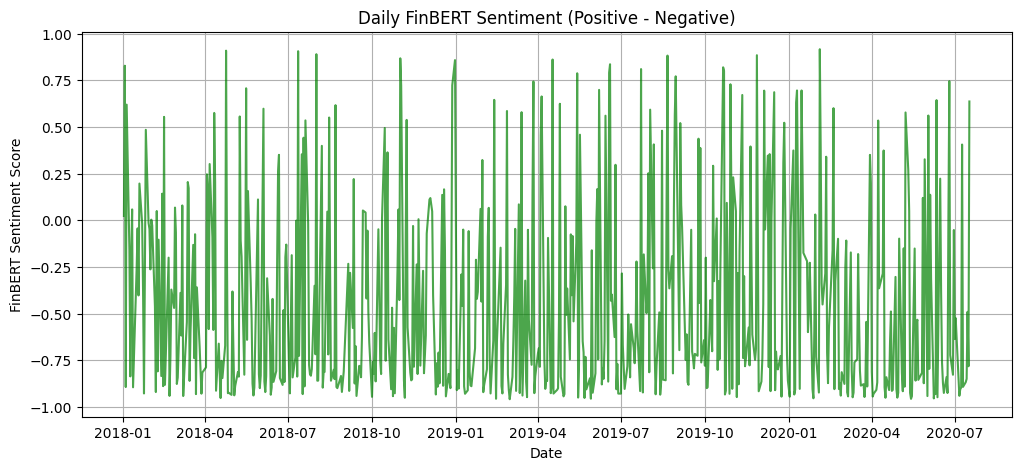

In [ ]:
plt.figure(figsize=(12,5))
finbert_signal = features_df['finbert_positive'] - features_df['finbert_negative']
plt.plot(features_df.index, finbert_signal, color='green', alpha=0.7)
plt.title("Daily FinBERT Sentiment (Positive - Negative)")
plt.xlabel("Date")
plt.ylabel("FinBERT Sentiment Score")
plt.grid(True)
plt.show()

the daily FinBERT sentiment signal is also quite volatile.

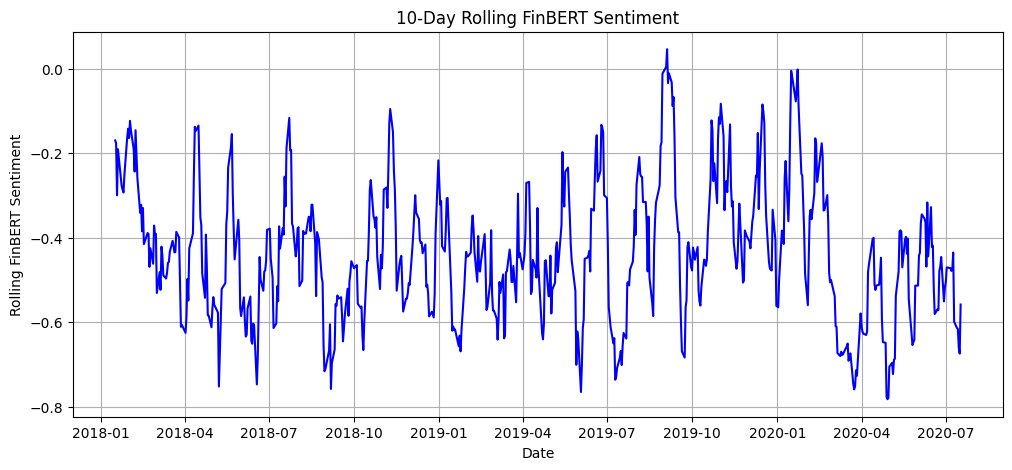

In [ ]:
plt.figure(figsize=(12,5))
rolling_finbert = finbert_signal.rolling(10).mean()
plt.plot(rolling_finbert, color='blue')
plt.title("10-Day Rolling FinBERT Sentiment")
plt.xlabel("Date")
plt.ylabel("Rolling FinBERT Sentiment")
plt.grid(True)
plt.show()

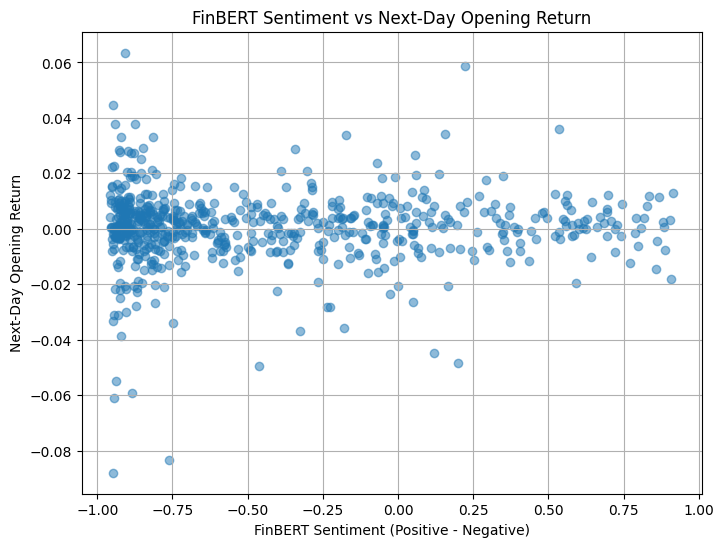

In [ ]:
features_df["Next_Open_Return"] = (
    (features_df["Next_Open_SPY"] - features_df["Open_SPY"])
    / features_df["Open_SPY"]
)

plt.figure(figsize=(8,6))
plt.scatter(
    finbert_signal,
    features_df["Next_Open_Return"],
    alpha=0.5
)
plt.title("FinBERT Sentiment vs Next-Day Opening Return")
plt.xlabel("FinBERT Sentiment (Positive - Negative)")
plt.ylabel("Next-Day Opening Return")
plt.grid(True)
plt.show()

This plot shows that there's no strong linear relationship between daily FinBERT sentiment and next day returns.

In [ ]:
features_df.columns

Index(['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'Return',
       'High_Low_Spread', 'Close_Open_Change', 'Close_to_High', 'Close_to_Low',
       'Return_1', 'Return_2', 'Return_3', 'Return_5', 'Return_10',
       'Momentum_3', 'Momentum_7', 'Close_lag1', 'Close_lag2', 'Close_lag3',
       'MA_5', 'MA_20', 'Close_minus_MA_5', 'Close_minus_MA_20',
       'Volatility_5', 'Volatility_10', 'Volatility_20', 'TR', 'ATR_14',
       'Prev_Day_Overnight_Return', 'day_of_week', 'month', 'day_of_month',
       'week_of_month', 'is_month_end', 'is_quarter_end', 'Next_Open_SPY',
       'headline_concat', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'finbert_positive', 'finbert_negative',
       'finbert_neutral', 'Next_Open_Return'],
      dtype='object')

In [ ]:
features_df.isna().sum()

,0
Close_SPY,0
High_SPY,0
Low_SPY,0
Open_SPY,0
Volume_SPY,0
Return,1
High_Low_Spread,0
Close_Open_Change,0
Close_to_High,0
Close_to_Low,0


In [ ]:
features_df = features_df.copy()
final_df = features_df.copy()
drop_cols = ["headline_concat"]

final_df = final_df.drop(columns=drop_cols, errors="ignore")
final_df = final_df.dropna()

In [ ]:
final_df.shape

(619, 45)

In [ ]:
final_df.isna().sum()

,0
Close_SPY,0
High_SPY,0
Low_SPY,0
Open_SPY,0
Volume_SPY,0
Return,0
High_Low_Spread,0
Close_Open_Change,0
Close_to_High,0
Close_to_Low,0


In [ ]:
# save dataset
final_df.to_csv("final_modeling_dataset.csv", index=True)

## heatmap

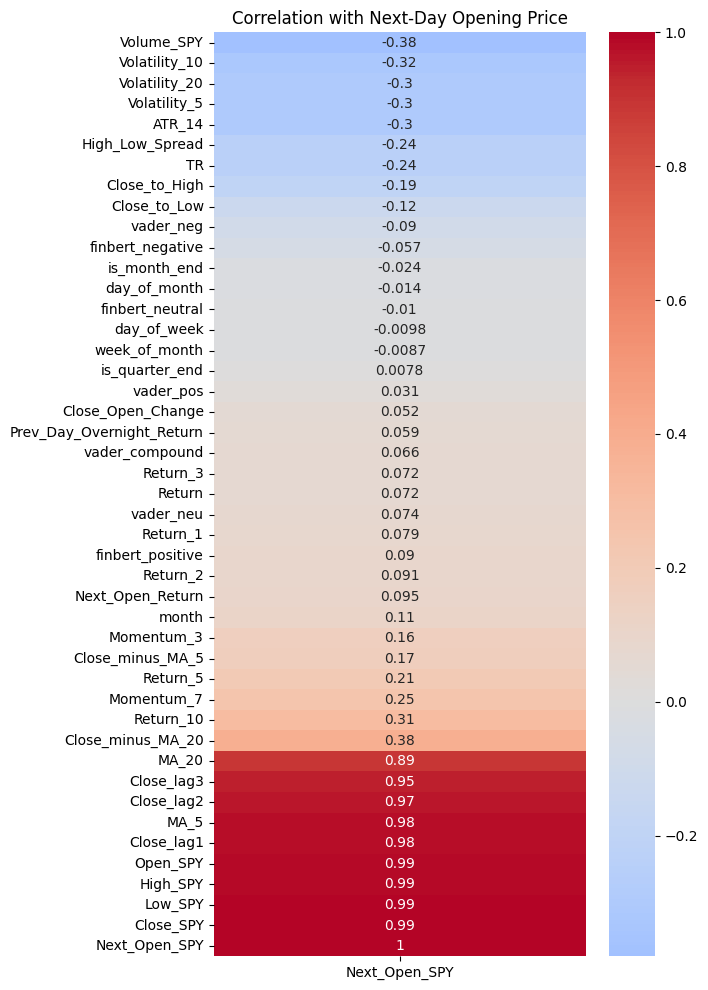

In [ ]:
target_corr = final_df.corr()["Next_Open_SPY"].sort_values()

plt.figure(figsize=(6,12))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with Next-Day Opening Price")
plt.show()


In [ ]:
sent_cols = ["vader_neg","vader_neu","vader_pos","vader_compound",
             "finbert_positive","finbert_negative","finbert_neutral"]

final_df[sent_cols + ["Next_Open_SPY"]].corr()

,vader_neg,vader_neu,vader_pos,vader_compound,finbert_positive,finbert_negative,finbert_neutral,Next_Open_SPY
vader_neg,1.000000,-0.333668,-0.109601,-0.546340,-0.089835,0.047232,0.023875,-0.089678
vader_neu,-0.333668,1.000000,-0.419689,-0.007695,-0.059806,0.077618,-0.051287,0.073736
vader_pos,-0.109601,-0.419689,1.000000,0.484424,0.137545,-0.103144,0.008297,0.031315
vader_compound,-0.546340,-0.007695,0.484424,1.000000,0.083539,-0.058738,-0.000645,0.066100
finbert_positive,-0.089835,-0.059806,0.137545,0.083539,1.000000,-0.726594,0.026426,0.089816
finbert_negative,0.047232,0.077618,-0.103144,-0.058738,-0.726594,1.000000,-0.706028,-0.056565
finbert_neutral,0.023875,-0.051287,0.008297,-0.000645,0.026426,-0.706028,1.000000,-0.010277
Next_Open_SPY,-0.089678,0.073736,0.031315,0.066100,0.089816,-0.056565,-0.010277,1.000000


none of the sentiment embeddings seem to have high correlation with the next day opening price.

## Data Dictionary

**Index**

- `Date` (DatetimeIndex)  
  - Trading day for which features are computed.  
  - All price, technical, sentiment, and calendar features for this date are used to predict the *next* day's opening price (`Next_Open_SPY`).

---

### Price & Return Features

| Column         | Type  | Description |
|----------------|-------|-------------|
| `Open_SPY`     | float | Opening price of SPY on `Date`. |
| `High_SPY`     | float | Highest intraday price of SPY on `Date`. |
| `Low_SPY`      | float | Lowest intraday price of SPY on `Date`. |
| `Close_SPY`    | float | Closing price of SPY on `Date`. |
| `Volume_SPY`   | float | Trading volume for SPY on `Date`. |
| `Return`       | float | Daily close-to-close return: `(Close_SPY − Close_SPY.shift(1)) / Close_SPY.shift(1)`. |

---

### Technical / Engineered Price Features

| Column                | Type  | Description |
|-----------------------|-------|-------------|
| `High_Low_Spread`     | float | Intraday trading range: `High_SPY - Low_SPY`. |
| `Close_Open_Change`   | float | Intraday price change: `Close_SPY - Open_SPY`. |
| `Close_to_High`       | float | Distance from close to intraday high. |
| `Close_to_Low`        | float | Distance from close to intraday low. |
| `Return_1`            | float | Lagged 1-day return. |
| `Return_2`            | float | Lagged 2-day return. |
| `Return_3`            | float | Lagged 3-day return. |
| `Return_5`            | float | 5-day percentage return. |
| `Return_10`           | float | 10-day percentage return. |
| `Momentum_3`          | float | 3-day momentum: `Close_SPY / Close_SPY.shift(3) − 1`. |
| `Momentum_7`          | float | 7-day momentum. |
| `Close_lag1`          | float | Previous day close. |
| `Close_lag2`          | float | Close price 2 days ago. |
| `Close_lag3`          | float | Close price 3 days ago. |
| `MA_5`                | float | 5-day simple moving average of `Close_SPY`. |
| `MA_20`               | float | 20-day simple moving average of `Close_SPY`. |
| `Close_minus_MA_5`    | float | Distance from close to 5-day MA. |
| `Close_minus_MA_20`   | float | Distance from close to 20-day MA. |
| `Volatility_5`        | float | 5-day rolling standard deviation of `Return`. |
| `Volatility_10`       | float | 10-day rolling standard deviation of `Return`. |
| `Volatility_20`       | float | 20-day rolling standard deviation of `Return`. |
| `TR`                  | float | True Range: max of intraday and close-based ranges. |
| `ATR_14`              | float | 14-day Average True Range. |
| `Prev_Day_Overnight_Return` | float | Overnight return from previous close to today’s open. |

---

### Calendar / Seasonality Features

| Column            | Type | Description |
|-------------------|------|-------------|
| `day_of_week`     | int  | Day of week (0 = Monday, …, 4 = Friday). |
| `month`           | int  | Month of year (1–12). |
| `day_of_month`    | int  | Day of the month (1–31). |
| `week_of_month`   | int  | Week index within the month (0–4). |
| `is_month_end`    | int  | 1 if `Date` is the final trading day of the month, else 0. |
| `is_quarter_end`  | int  | 1 if `Date` is the final trading day of the quarter, else 0. |

---

### VADER Sentiment Features (Aggregated Headlines for `Date`)

| Column           | Type  | Description |
|------------------|-------|-------------|
| `vader_neg`      | float | Proportion of negative sentiment. |
| `vader_neu`      | float | Proportion of neutral sentiment. |
| `vader_pos`      | float | Proportion of positive sentiment. |
| `vader_compound` | float | Overall VADER sentiment score in \[-1, 1]. |

---

### FinBERT Sentiment Features (Aggregated Headlines for `Date`)

| Column              | Type  | Description |
|---------------------|-------|-------------|
| `finbert_positive`  | float | FinBERT-estimated probability that news is positive. |
| `finbert_negative`  | float | FinBERT-estimated probability that news is negative. |
| `finbert_neutral`   | float | FinBERT-estimated probability that news is neutral. |

---

### Target Variables

| Column             | Type  | Description |
|--------------------|-------|-------------|
| `Next_Open_SPY`    | float | **Next-day opening price** of SPY (prediction target). |
| `Next_Open_Return` | float | Next-day open return: `(Next_Open_SPY − Open_SPY) / Open_SPY`. Useful for EDA. |

